In [1]:
import pandas as pd
import math
from datetime import datetime
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Embedding, Flatten, Input, concatenate
from keras_tuner import BayesianOptimization, RandomSearch
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import keras.backend as K
import sklearn
import category_encoders as ce
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping
from sklearn.metrics import log_loss
from keras import regularizers
from sklearn.model_selection import train_test_split
from keras import initializers

# 1. Data Exploration

## Data Import

In [2]:
# Import the training data
df_train = pd.read_csv('Project Data/ProjectTrainingData.csv')

In [3]:
df_train_sample = df_train.sample(frac = 0.1, random_state = 42)

In [4]:
df_train = df_train_sample

In [5]:
# Import the test data
df_test = pd.read_csv('Project Data/ProjectTestData.csv')

In [6]:
# Add click column to test dataset, merge it with train dataset to do feature engineering
df_test['click'] = 2
df_test = df_test[['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 
                    'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']]

In [7]:
df = pd.concat([df_train, df_test])

In [8]:
del(df_train)
del(df_test)

In [9]:
df = df.reset_index()

## Data Overview

In [10]:
# Explore the training data
df.head()

,index,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,8165300,7.902527e+18,0,14102221,1005,1,a7853007,7e091613,f028772b,ecad2386,...,1,0,9478,320,50,906,3,1451,100156,61
1,30286524,1.400962e+19,0,14102911,1002,0,5b787406,f3ca2e42,50e219e0,ecad2386,...,0,0,23438,320,50,2684,2,1327,-1,52
2,14989769,2.411564e+18,0,14102504,1005,0,85f751fd,c4e18dd6,50e219e0,e986f7ef,...,1,2,20395,320,50,2340,3,41,100111,159
3,30874747,5.087266e+18,0,14102914,1005,0,85f751fd,c4e18dd6,50e219e0,92f5800b,...,1,2,21191,320,50,2424,1,175,100189,71
4,30748074,1.107625e+19,0,14102914,1010,1,85f751fd,c4e18dd6,50e219e0,04f2be5f,...,4,3,23551,320,50,2698,0,163,100084,212


In [11]:
df.shape

(16214450, 25)

In [12]:
df.describe()

,index,id,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,1.621445e+07,1.621445e+07,1.621445e+07,1.621445e+07,1.621445e+07,1.621445e+07,1.621445e+07,1.621445e+07,1.621445e+07,1.621445e+07,1.621445e+07,1.621445e+07,1.621445e+07,1.621445e+07,1.621445e+07,1.621445e+07
mean,8.381294e+06,9.223162e+18,1.638922e+00,1.410281e+07,1.004968e+03,2.555573e-01,1.008683e+00,3.487597e-01,2.011066e+04,3.193333e+02,5.983931e+01,2.270022e+03,1.396751e+00,2.246153e+02,5.252635e+04,9.083736e+01
std,6.514856e+06,5.326250e+18,7.471653e-01,3.337277e+02,1.010967e+00,4.899744e-01,4.757303e-01,8.646333e-01,4.684603e+03,2.311163e+01,4.659339e+01,5.820898e+02,1.326887e+00,3.316403e+02,4.999721e+04,7.931550e+01
min,0.000000e+00,5.211594e+11,0.000000e+00,1.410210e+07,1.001000e+03,0.000000e+00,0.000000e+00,0.000000e+00,3.750000e+02,1.200000e+02,2.000000e+01,1.120000e+02,0.000000e+00,3.300000e+01,-1.000000e+00,1.000000e+00
25%,3.685480e+06,4.610198e+18,2.000000e+00,1.410252e+07,1.005000e+03,0.000000e+00,1.000000e+00,0.000000e+00,1.789400e+04,3.200000e+02,5.000000e+01,1.994000e+03,0.000000e+00,3.500000e+01,-1.000000e+00,2.300000e+01
50%,7.371044e+06,9.224959e+18,2.000000e+00,1.410300e+07,1.005000e+03,0.000000e+00,1.000000e+00,0.000000e+00,2.176700e+04,3.200000e+02,5.000000e+01,2.502000e+03,2.000000e+00,3.900000e+01,1.000310e+05,5.200000e+01
75%,1.105591e+07,1.383615e+19,2.000000e+00,1.410310e+07,1.005000e+03,0.000000e+00,1.000000e+00,0.000000e+00,2.316100e+04,3.200000e+02,5.000000e+01,2.667000e+03,3.000000e+00,2.950000e+02,1.001060e+05,1.570000e+02
max,3.199109e+07,1.844674e+19,2.000000e+00,1.410312e+07,1.012000e+03,7.000000e+00,5.000000e+00,5.000000e+00,2.434900e+04,1.024000e+03,1.024000e+03,2.793000e+03,3.000000e+00,1.839000e+03,1.002480e+05,2.550000e+02


In [13]:
# check missing value
df.isna().sum()
# No missing value for feature variables

index               0
id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

## Categorical Data Exploration & Engineering

In [14]:
def category_engineering(dist_category, threshold, category):
    dist = dist_category.reset_index()
    dist['freq_sum'] = dist['click'].cumsum()
    # set a threshold; that is, the X% site_domain with smallest frequencies will be set as "others"
    thres = dist['click'].sum() * (1 - threshold)
    # check the number of site_domain above X%
    print('Number of categories after engineering is', dist[dist['freq_sum'] >= thres]['click'].count() + 1)
    lst = dist[dist['freq_sum'] >= thres][category].tolist()
    df['temp'] = 'others'
    df.loc[df[category].isin(lst), 'temp'] = df[category]
    df[category] = df['temp'].values

### site_id

In [15]:
# check the number of unique values for each column
df['site_id'].nunique()

4168

<AxesSubplot:xlabel='site_id'>

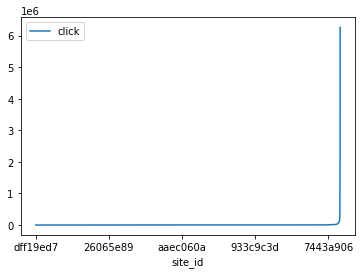

In [16]:
# check the frequency distribution of values
dist_site_id = df.groupby(by = 'site_id').count()['click'].sort_values(ascending=True).to_frame()
# visualize the frequency distribution
dist_site_id.plot()

the distribution is extremely unbalanced. we try to set the values with small frequency to "others"

In [17]:
category_engineering(dist_site_id, 0.9, 'site_id')

Number of categories after engineering is 75


Then the new column should contain 86 variables. we can do encoding then

In [18]:
df['site_id']

0           a7853007
1           5b787406
2           85f751fd
3           85f751fd
4           85f751fd
              ...   
16214445      others
16214446    e151e245
16214447    17d1b03f
16214448    85f751fd
16214449    856e6d3f
Name: site_id, Length: 16214450, dtype: object

In [19]:
del(dist_site_id)
df = df.loc[:, ~df.columns.isin(['index', 'temp'])]

### site_domain

In [20]:
df['site_domain'].nunique()

5785

In [21]:
# check the frequency distribution of values
dist_site_domain = df.groupby(by = 'site_domain').count()['click'].sort_values(ascending = True).to_frame()

<AxesSubplot:xlabel='site_domain'>

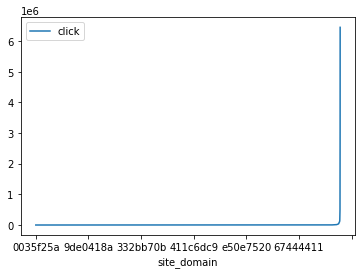

In [22]:
dist_site_domain.plot()

In [23]:
category_engineering(dist_site_domain, 0.9, 'site_domain')

Number of categories after engineering is 48


In [24]:
df['site_domain']

0           7e091613
1             others
2           c4e18dd6
3           c4e18dd6
4           c4e18dd6
              ...   
16214445      others
16214446    7e091613
16214447    f3845767
16214448    c4e18dd6
16214449    58a89a43
Name: site_domain, Length: 16214450, dtype: object

### site_category

In [25]:
df['site_category'].nunique()

25

we can directly use label encoding for this column

### app_id

In [26]:
df['app_id'].nunique()

7187

<AxesSubplot:xlabel='app_id'>

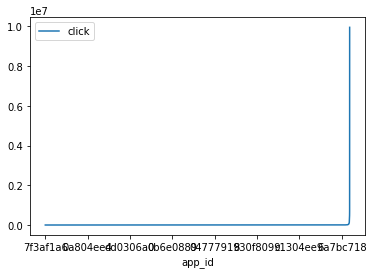

In [27]:
dist_app_id = df.groupby(by = 'app_id').count()['click'].sort_values(ascending = True).to_frame()
dist_app_id.plot()

In [28]:
category_engineering(dist_app_id, 0.9, 'app_id')

Number of categories after engineering is 33


### app_domain

In [29]:
df['app_domain'].nunique()

430

<AxesSubplot:xlabel='app_domain'>

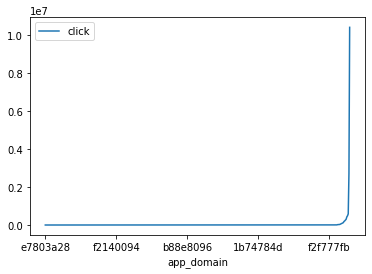

In [30]:
dist_app_domain = df.groupby(by = 'app_domain').count()['click'].sort_values(ascending = True).to_frame()
dist_app_domain.plot()

In [31]:
category_engineering(dist_app_domain, 0.9, 'app_domain')

Number of categories after engineering is 6


### app_category

In [32]:
df['app_category'].nunique()

33

we can use label encoding directly to process this column

### device_id

In [33]:
df['device_id'].nunique()

1296455

Too many categories; intuitively, the device id is not informative as well. Just delete it then

### device_ip

In [34]:
df['device_ip'].nunique()

3912984

Same situation as device_id. delete it then

### device_model

In [35]:
df['device_model'].nunique()

7265

<AxesSubplot:xlabel='device_model'>

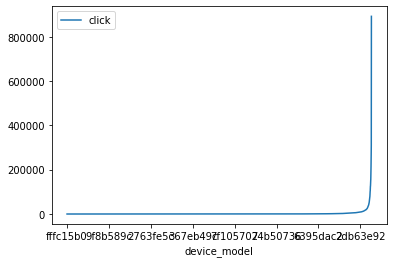

In [36]:
dist_dev_model = df.groupby(by = 'device_model').count()['click'].sort_values(ascending = True).to_frame()
dist_dev_model.plot()

In [37]:
category_engineering(dist_dev_model, 0.5, 'device_model')

Number of categories after engineering is 46


### The Anonymized Categorical Variables: C1, C14-C21

In [38]:
df['C1'].nunique()

7

directly do label encoding

In [39]:
df['C14'].nunique()

2808

<AxesSubplot:xlabel='C14'>

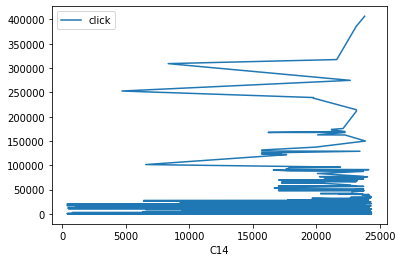

In [40]:
dist_c14 = df.groupby(by = 'C14').count()['click'].sort_values(ascending = True).to_frame()
dist_c14.plot()

In [41]:
category_engineering(dist_c14, 0.5, 'C14')

Number of categories after engineering is 59


In [42]:
df['C15'].nunique()

8

In [43]:
df['C16'].nunique()

9

In [44]:
df['C17'].nunique()

472

<AxesSubplot:xlabel='C17'>

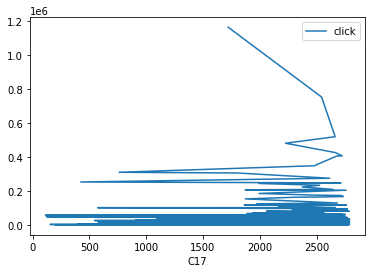

In [45]:
dist_c17 = df.groupby(by = 'C17').count()['click'].sort_values(ascending = True).to_frame()
dist_c17.plot()

In [46]:
category_engineering(dist_c17, 0.5, 'C17')

Number of categories after engineering is 24


In [47]:
df['C18'].nunique()

4

In [48]:
df['C19'].nunique()

68

In [49]:
df['C20'].nunique()

171

<AxesSubplot:xlabel='C20'>

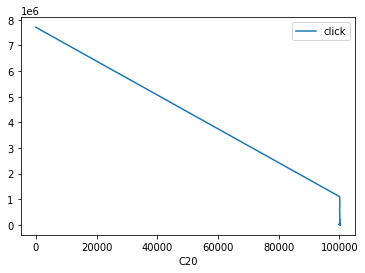

In [50]:
dist_c20 = df.groupby(by = 'C20').count()['click'].sort_values(ascending = True).to_frame()
dist_c20.plot()

In [51]:
category_engineering(dist_c20, 0.9, 'C20')

Number of categories after engineering is 24


In [52]:
df['C21'].nunique()

62

<AxesSubplot:xlabel='C21'>

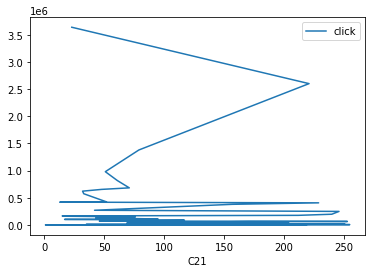

In [53]:
dist_c21 = df.groupby(by = 'C21').count()['click'].sort_values(ascending = True).to_frame()
dist_c21.plot()

In [54]:
category_engineering(dist_c21, 0.9, 'C21')

Number of categories after engineering is 19


In [55]:
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,temp
0,7.902527e+18,0,14102221,1005,1,a7853007,7e091613,f028772b,ecad2386,7801e8d9,...,0,others,320,50,others,3,1451,100156,61,61
1,1.400962e+19,0,14102911,1002,0,5b787406,others,50e219e0,ecad2386,7801e8d9,...,0,23438,320,50,others,2,1327,-1,52,52
2,2.411564e+18,0,14102504,1005,0,85f751fd,c4e18dd6,50e219e0,others,2347f47a,...,2,others,320,50,others,3,41,100111,others,others
3,5.087266e+18,0,14102914,1005,0,85f751fd,c4e18dd6,50e219e0,92f5800b,ae637522,...,2,21191,320,50,2424,1,175,100189,71,71
4,1.107625e+19,0,14102914,1010,1,85f751fd,c4e18dd6,50e219e0,others,7801e8d9,...,3,others,320,50,others,0,163,100084,212,212


In [56]:
df = df.drop('temp', axis = 1)

In [57]:
del(df_train_sample)
del(dist_app_domain)
del(dist_app_id)
del(dist_c14)
del(dist_c17)
del(dist_c20)
del(dist_c21)
del(dist_dev_model)
del(dist_site_domain)

# 2. Data Processing

## Categorical Feature Encoding & Numerical Feature Engineering

id

In [58]:
# Drop the id column; index column is usually not insightful for machine learning models
df = df.drop(['id'], axis=1)

hour

In [59]:
# Divide the hour column into two: Day & Hour
df['Day'] = df['hour'] // 100
df['Hour'] = df['hour'] - df['Day'] * 100

In [60]:
# Delete the original hour column
df = df.drop(['hour'], axis = 1)

site_id, site_domain, site_category

In [62]:
encoder= ce.BaseNEncoder(cols=['site_id'],return_df=True,base=10)
df = encoder.fit_transform(df)

In [63]:
encoder= ce.BaseNEncoder(cols=['site_domain'],return_df=True,base=10)
df = encoder.fit_transform(df)

In [64]:
encoder = ce.OrdinalEncoder(cols=['site_category'], return_df=True)
df = encoder.fit_transform(df)

app_id, app_domain, app_category

In [65]:
encoder= ce.BaseNEncoder(cols=['app_id'],return_df=True,base=10)
df = encoder.fit_transform(df)

In [66]:
encoder = ce.OrdinalEncoder(cols=['app_domain'], return_df=True)
df = encoder.fit_transform(df)

In [67]:
encoder= ce.BaseNEncoder(cols=['app_category'],return_df=True,base=10)
df = encoder.fit_transform(df)

device_id, device_ip, device_model

In [68]:
df = df.drop(['device_id', 'device_ip'], axis=1)

In [69]:
encoder= ce.BaseNEncoder(cols=['device_model'],return_df=True,base=10)
df = encoder.fit_transform(df)

C1, C14-21

In [70]:
encoder = ce.OrdinalEncoder(cols=['C1'], return_df=True)
df = encoder.fit_transform(df)

In [71]:
encoder= ce.BaseNEncoder(cols=['C14'],return_df=True,base=10)
df = encoder.fit_transform(df)

In [72]:
encoder = ce.OrdinalEncoder(cols=['C15'], return_df=True)
df = encoder.fit_transform(df)

In [73]:
encoder = ce.OrdinalEncoder(cols=['C16'], return_df=True)
df = encoder.fit_transform(df)

In [74]:
encoder = ce.OrdinalEncoder(cols=['C17'], return_df=True)
df = encoder.fit_transform(df)

In [75]:
encoder = ce.OrdinalEncoder(cols=['C18'], return_df=True)
df = encoder.fit_transform(df)

In [76]:
encoder = ce.OrdinalEncoder(cols=['C19'], return_df=True)
df = encoder.fit_transform(df)

In [77]:
encoder = ce.OrdinalEncoder(cols=['C20'], return_df=True)
df = encoder.fit_transform(df)

In [78]:
encoder = ce.OrdinalEncoder(cols=['C21'], return_df=True)
df = encoder.fit_transform(df)

In [79]:
df.head()

,click,C1,banner_pos,site_id_0,site_id_1,site_domain_0,site_domain_1,site_category,app_id,app_domain,...,C14_1,C15,C16,C17,C18,C19,C20,C21,Day,Hour
0,0,1,1,0,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,141022,21
1,0,2,0,0,2,0,2,2,1,1,...,2,1,1,1,2,2,2,2,141029,11
2,0,1,0,0,3,0,3,2,2,2,...,1,1,1,1,1,3,3,3,141025,4
3,0,1,0,0,3,0,3,2,3,3,...,3,1,1,2,3,4,4,4,141029,14
4,0,3,1,0,3,0,3,2,2,1,...,1,1,1,1,4,5,5,5,141029,14


## Feature Selection

In [80]:
df_train = df[df['click'] != 2]
df_test = df[df['click'] == 2].drop('click', axis = 1)

In [81]:
df_train.head()

,click,C1,banner_pos,site_id_0,site_id_1,site_domain_0,site_domain_1,site_category,app_id,app_domain,...,C14_1,C15,C16,C17,C18,C19,C20,C21,Day,Hour
0,0,1,1,0,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,141022,21
1,0,2,0,0,2,0,2,2,1,1,...,2,1,1,1,2,2,2,2,141029,11
2,0,1,0,0,3,0,3,2,2,2,...,1,1,1,1,1,3,3,3,141025,4
3,0,1,0,0,3,0,3,2,3,3,...,3,1,1,2,3,4,4,4,141029,14
4,0,3,1,0,3,0,3,2,2,1,...,1,1,1,1,4,5,5,5,141029,14


Text(0.5, 1.0, 'Correlation Heatmap')

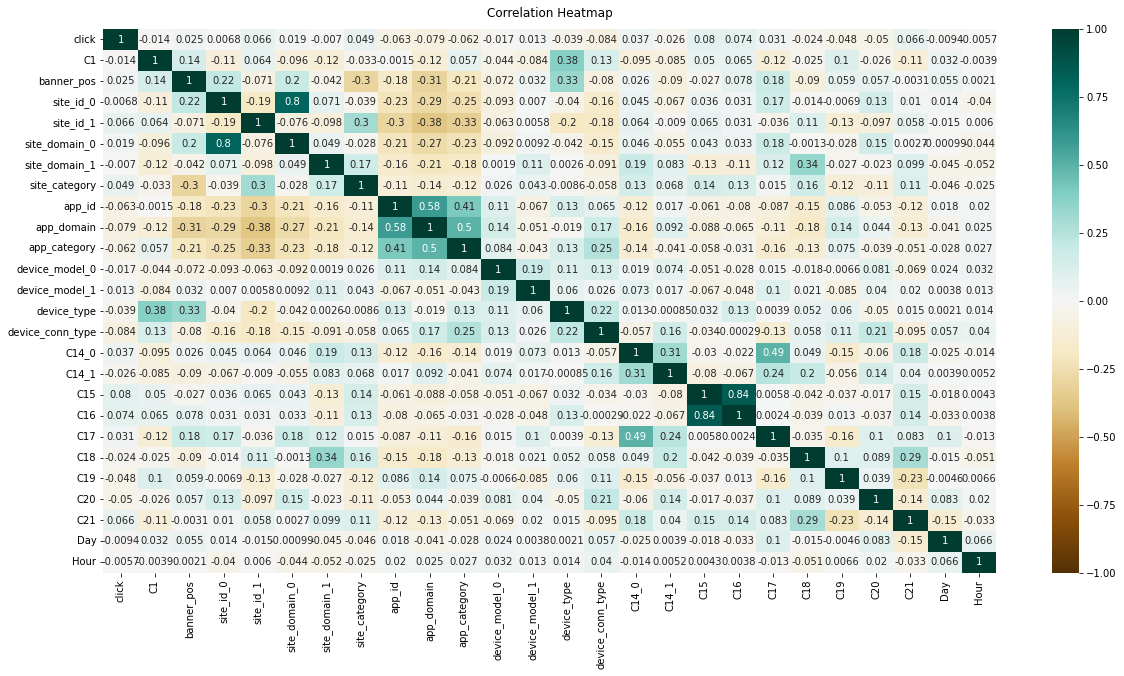

In [82]:
import seaborn as sns

plt.figure(figsize=(20, 10))

heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

# 2. Modelling

In [83]:
# Split the data
X = df_train.drop('click', axis = 1)
y = df_train['click']

In [84]:
del(df)

In [85]:
# Split to Train & Validation dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest

In [86]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 100, criterion = "entropy", random_state = 42, 
                            min_samples_split=300, max_depth=30, n_jobs=4)

rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=30, min_samples_split=300,
                       n_jobs=4, random_state=42)

In [87]:
prediction_rf = rf.predict_proba(X_test)
log_loss(y_test, prediction_rf)

0.3989153217604901

## Logistic Regression

In [88]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42,n_jobs=-1,penalty="l2").fit(X_train, y_train)

In [89]:
prediction_lr = clf.predict_proba(X_test)
log_loss(y_test, prediction_lr)

0.4547223118532734

## XGBoost

In [90]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
xgb = XGBClassifier(objective = 'binary:logistic', nthread = 4, seed = 42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=4, nthread=4, num_parallel_tree=1, predictor='auto', ...)

In [91]:
prediction_xgb = xgb.predict_proba(X_test)
log_loss(y_test, prediction_xgb)

0.4009198040222743

## Neural Network

try to build up a simple nn model

In [95]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)  

In [96]:
model = Sequential()
model.add(Dense(512, input_shape=(25, ), activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [97]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-3))

In [99]:
model.fit(X_train_scale, y_train, epochs = 9, batch_size = 4096, validation_data=(X_test_scale, y_test), verbose=1)

Epoch 1/9
625/625 [==============================] - 15s 23ms/step - loss: 0.4077 - val_loss: 6499.0410
Epoch 2/9
625/625 [==============================] - 15s 25ms/step - loss: 0.4065 - val_loss: 6067.4619
Epoch 3/9
625/625 [==============================] - 15s 24ms/step - loss: 0.4054 - val_loss: 7012.7271
Epoch 4/9
625/625 [==============================] - 14s 23ms/step - loss: 0.4047 - val_loss: 7956.7168
Epoch 5/9
625/625 [==============================] - 14s 23ms/step - loss: 0.4041 - val_loss: 8622.8291
Epoch 6/9
625/625 [==============================] - 14s 22ms/step - loss: 0.4034 - val_loss: 7635.9600
Epoch 7/9
625/625 [==============================] - 14s 22ms/step - loss: 0.4029 - val_loss: 7993.3984
Epoch 8/9
625/625 [==============================] - 14s 22ms/step - loss: 0.4026 - val_loss: 7767.7964
Epoch 9/9
625/625 [==============================] - 14s 22ms/step - loss: 0.4022 - val_loss: 9320.4521


In [100]:
prediction_nn = model.predict(X_test_scale)
log_loss(y_test, prediction_nn)

19995/19995 [==============================] - 14s 707us/step


0.4036392252171728

# 3. Hyperparameter Tuning

## Random Forest

In [ ]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': range(100, 300, 50),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : range(5, 10, 1),
}
CV_rfc = GridSearchCV(estimator=rfc,
    param_grid=param_grid,
    cv=5,
    scoring='neg_log_loss',
    n_jobs=4)
CV_rfc.fit(X_train, y_train)

In [ ]:
print("Parameter: ", CV_rfc.best_params_)
print("Non-nested AUC: ", CV_rfc.best_score_)
print("Best Estimator: ", CV_rfc.best_estimator_)

## XGBoost

In [ ]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42

)

param_grid = {
    'max_depth': range(5, 10, 1),
    'n_estimators': range(100, 300, 50),
    'learning_rate': [0.1, 0.01, 0.03, 0.05]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring = 'neg_log_loss',
    n_jobs= 10,
    cv = 5,
    verbose=True

)

grid_search.fit(X_train, y_train)

print(" Results from Grid Search " )

print("\n The best estimator across ALL searched params:\n",grid_search.best_estimator_)

print("\n The best score across ALL searched params:\n",grid_search.best_score_)

print("\n The best parameters across ALL searched params:\n",grid_search.best_params_)

# 4. Predict the test dataset

In [ ]:
# Choose the best performing model for validation dataset
model

In [ ]:
pred = model.predict(df_test)
df_pred = pd.DataFrame({'click': pred})
#pred = model.predict_proba(df_test)
#df_pred = pd.DataFrame({'click': pred[:, 1]})
df_pred.to_csv('Team12/ProjectSubmission-Team12.csv', index=False)